In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import _LRScheduler

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

from sklearn import manifold

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

100%|██████████| 170498071/170498071 [00:01<00:00, 101852351.73it/s]


Extracting .data/cifar-10-python.tar.gz to .data


Using transforms for data augmentation. Flip, crop and rotation is used to increase data diversity. Color channels are normalized using mean and standard deviation

In [4]:
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomVerticalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

Splitting data into, Training, validation, and testing sets

In [5]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Files already downloaded and verified
Files already downloaded and verified


Creating data loaders for training, validation and test sets.

In [6]:
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle=False)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Batches in train dataset: %d" % (len(train_iterator)))
print("Batches in testing dataset: %d" % (len(test_iterator)))

print("Number of images in train dataset: %d" % (len(train_iterator) * BATCH_SIZE))
print("Number of images in testing dataset: %d" % (len(test_iterator) * BATCH_SIZE))

Batches in train dataset: 176
Batches in testing dataset: 40
Number of images in train dataset: 45056
Number of images in testing dataset: 10240


The custom model for resnet is created having 4,735,658 trainable parameters

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.functional.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet(ResidualBlock, [3, 4, 4, 3]).to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
     ResidualBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
    ResidualBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

In [9]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [10]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        pred = y_pred.argmax(1, keepdim = True)
        correct = pred.eq(y.view_as(pred)).sum()
        acc = correct.float() / y.shape[0]
        
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()


        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            pred = y_pred.argmax(1, keepdim = True)
            correct = pred.eq(y.view_as(pred)).sum()
            acc = correct.float() / y.shape[0]
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Experiment: Training with Adam optimizer using 0.001 learning rate and weight_decay (L2 regularization) value of 0.0001

In [14]:
model = ResNet(ResidualBlock, [3, 4, 4, 3]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 )

EPOCHS = 50

best_validation_loss = float('inf')

for epoch in range(EPOCHS):
  
  train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, device)
  validation_loss, validation_accuracy = evaluate(model, valid_iterator, criterion, device)
  
  if validation_loss<best_validation_loss:
    torch.save(model, "best_model_new.pt")
    best_validation_loss=validation_loss 

  print (f"Epoch: {epoch+1} \ Training Loss={train_loss:.2f} \ Training Accuracy: {train_accuracy:.2f} ")
  print (f"Epoch: {epoch+1} \ Validation Loss={validation_loss:.2f} \ Validation Accuracy: {validation_accuracy:.2f}" ) 

Epoch: 1 \ Training Loss=1.61 \ Training Accuracy: 0.40 
Epoch: 1 \ Validation Loss=1.39 \ Validation Accuracy: 0.48
Epoch: 2 \ Training Loss=1.23 \ Training Accuracy: 0.55 
Epoch: 2 \ Validation Loss=1.18 \ Validation Accuracy: 0.58
Epoch: 3 \ Training Loss=1.03 \ Training Accuracy: 0.63 
Epoch: 3 \ Validation Loss=1.00 \ Validation Accuracy: 0.65
Epoch: 4 \ Training Loss=0.92 \ Training Accuracy: 0.67 
Epoch: 4 \ Validation Loss=1.06 \ Validation Accuracy: 0.63
Epoch: 5 \ Training Loss=0.83 \ Training Accuracy: 0.70 
Epoch: 5 \ Validation Loss=0.99 \ Validation Accuracy: 0.66
Epoch: 6 \ Training Loss=0.78 \ Training Accuracy: 0.72 
Epoch: 6 \ Validation Loss=0.87 \ Validation Accuracy: 0.70
Epoch: 7 \ Training Loss=0.73 \ Training Accuracy: 0.74 
Epoch: 7 \ Validation Loss=0.93 \ Validation Accuracy: 0.68
Epoch: 8 \ Training Loss=0.68 \ Training Accuracy: 0.76 
Epoch: 8 \ Validation Loss=0.92 \ Validation Accuracy: 0.69
Epoch: 9 \ Training Loss=0.64 \ Training Accuracy: 0.77 
Epoch: 

Exp: Training with SGD optimizer using 0.1 learning rate and weight_decay (L2 regularization) value of 0.0001 and momentum=0.5. Also, we are using ReduceLROnPlateau to decrease learning rate as the training progresses

In [16]:
model = ResNet(ResidualBlock, [3, 4, 4, 3]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum =0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

EPOCHS = 75

best_validation_loss = float('inf')

for epoch in range(EPOCHS):
  
  train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, device)
  validation_loss, validation_accuracy = evaluate(model, valid_iterator, criterion, device)
  scheduler.step(validation_loss)

  if validation_loss<best_validation_loss:
    torch.save(model, "best_model_new.pt")
    best_validation_loss=validation_loss 

  print (f"Epoch: {epoch+1} \ Training Loss={train_loss:.2f} \ Training Accuracy: {train_accuracy:.2f} ")
  print (f"Epoch: {epoch+1} \ Validation Loss={validation_loss:.2f} \ Validation Accuracy: {validation_accuracy:.2f}" ) 

Epoch: 1 \ Training Loss=1.77 \ Training Accuracy: 0.34 
Epoch: 1 \ Validation Loss=1.54 \ Validation Accuracy: 0.44
Epoch: 2 \ Training Loss=1.35 \ Training Accuracy: 0.50 
Epoch: 2 \ Validation Loss=1.73 \ Validation Accuracy: 0.45
Epoch: 3 \ Training Loss=1.14 \ Training Accuracy: 0.59 
Epoch: 3 \ Validation Loss=1.11 \ Validation Accuracy: 0.60
Epoch: 4 \ Training Loss=1.00 \ Training Accuracy: 0.64 
Epoch: 4 \ Validation Loss=1.20 \ Validation Accuracy: 0.59
Epoch: 5 \ Training Loss=0.91 \ Training Accuracy: 0.67 
Epoch: 5 \ Validation Loss=1.00 \ Validation Accuracy: 0.65
Epoch: 6 \ Training Loss=0.83 \ Training Accuracy: 0.70 
Epoch: 6 \ Validation Loss=0.98 \ Validation Accuracy: 0.66
Epoch: 7 \ Training Loss=0.77 \ Training Accuracy: 0.72 
Epoch: 7 \ Validation Loss=0.88 \ Validation Accuracy: 0.70
Epoch: 8 \ Training Loss=0.71 \ Training Accuracy: 0.75 
Epoch: 8 \ Validation Loss=0.86 \ Validation Accuracy: 0.72
Epoch: 9 \ Training Loss=0.66 \ Training Accuracy: 0.76 
Epoch: 

Exp: Training with SGD optimizer using 0.01 learning rate and weight_decay (L2 regularization) value of 0.001 and momentum=0.9. Also, we are using CosineAnnealingLR to decrease learning rate as the training progresses

In [ ]:
model = ResNet(ResidualBlock, [3, 4, 4, 3]).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
train_loss_history = []
val_loss_history = []

EPOCHS = 100

best_validation_loss = float('inf')

for epoch in range(EPOCHS):
  
  train_loss, train_accuracy = train(model, train_iterator, optimizer, criterion, device)
  # train_loss, train_accuracy = train_with_scheduler(model, train_iterator, optimizer, scheduler, criterion, device)
  scheduler.step()
  validation_loss, validation_accuracy = evaluate(model, valid_iterator, criterion, device)
  
  if validation_loss<best_validation_loss:
    torch.save(model, "best_model_new.pt")
    best_validation_loss=validation_loss 
  
  train_loss_history.append(train_loss)
  val_loss_history.append(validation_loss)

  print (f"Epoch: {epoch+1} \ Training Loss={train_loss:.2f} \ Training Accuracy: {train_accuracy:.2f} ")
  print (f"Epoch: {epoch+1} \ Validation Loss={validation_loss:.2f} \ Validation Accuracy: {validation_accuracy:.2f}" ) 

Epoch: 1 \ Training Loss=1.71 \ Training Accuracy: 0.35 
Epoch: 1 \ Validation Loss=1.60 \ Validation Accuracy: 0.41
Epoch: 2 \ Training Loss=1.31 \ Training Accuracy: 0.52 
Epoch: 2 \ Validation Loss=1.25 \ Validation Accuracy: 0.56
Epoch: 3 \ Training Loss=1.09 \ Training Accuracy: 0.61 
Epoch: 3 \ Validation Loss=1.32 \ Validation Accuracy: 0.57
Epoch: 4 \ Training Loss=0.95 \ Training Accuracy: 0.66 
Epoch: 4 \ Validation Loss=1.00 \ Validation Accuracy: 0.66
Epoch: 5 \ Training Loss=0.85 \ Training Accuracy: 0.69 
Epoch: 5 \ Validation Loss=0.86 \ Validation Accuracy: 0.69
Epoch: 6 \ Training Loss=0.77 \ Training Accuracy: 0.73 
Epoch: 6 \ Validation Loss=0.84 \ Validation Accuracy: 0.71
Epoch: 7 \ Training Loss=0.72 \ Training Accuracy: 0.74 
Epoch: 7 \ Validation Loss=0.74 \ Validation Accuracy: 0.74
Epoch: 8 \ Training Loss=0.68 \ Training Accuracy: 0.76 
Epoch: 8 \ Validation Loss=0.70 \ Validation Accuracy: 0.76
Epoch: 9 \ Training Loss=0.64 \ Training Accuracy: 0.78 
Epoch: 

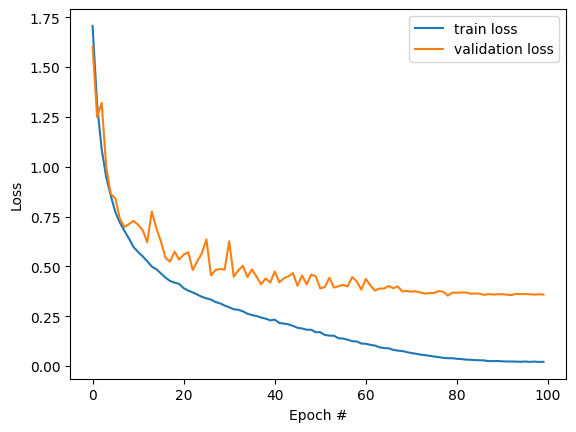

In [ ]:
plt.plot(train_loss_history, label="train loss")
plt.plot(val_loss_history, label="validation loss")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
best_model = torch.load("best_model_new.pt")
test_loss, test_accuracy = evaluate(best_model, test_iterator, criterion, device)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.902734375
